# Data Processing

In [4]:
#Importing main packages

import numpy as np
import tensorflow as tf
import cv2

## Files preprocessing
The main problem is that a 1.5GB JSON file is pretty much untractable, so i decided to split in one JSON per each image, deleting all useless information like lines and drivable areas.

Other than that, it seems like there are 140 images w/o label. That's pretty strange since i didn't see anyone ever mentioning it on the forums, but for now i will delete them and act like they never existed.

In [5]:
import pathlib
main_folder = str(pathlib.Path.cwd().joinpath('dataset_bdd', 'labels'))

json_train_dir = main_folder + '/bdd100k_labels_images_train.json'
json_val_dir = main_folder + '/bdd100k_labels_images_validation.json'

folder_train = main_folder + '/train_jsons/'
folder_val = main_folder + '/val_jsons/'

### Dividing data into different single JSONs
And using more useful coordinates to describe the bounding boxes

In [6]:
import json

#A function to get more meaningful values to describe the bounding boxes
def pov_change(x1,x2,y1,y2):
    xb = (x1+x2)/(2)
    yb = (y1+y2)/(2)
    wb = abs(x1-x2)/2
    hb = abs(y1-y2)/2
    return xb,yb,wb,hb

#Loading a JSON file into a Python variable
def json_parser(path):
    # Parsing
    with open(path, 'r') as read_file:
        data = json.load(read_file)
    return data

In [7]:
#Cleaning a JSON file from all the useless information (in respect to our task)
def json_cleaner(data):
    # Cleaning timestamps and not so useful attributes
    for item in data:
        del item['attributes']
        del item['timestamp']

    # Cleaning drivable area and lanes
    for item in data:
        storing_indexes = []
        for index, i in enumerate(item['labels']):
            del i['attributes']
            del i['manualShape']
            del i['manualAttributes']
            if 'box2d' in i:
                xb,yb,wb,hb = pov_change(i['box2d']['x1'],i['box2d']['x2'],i['box2d']['y1'],i['box2d']['y2'])
                i['box2d']['xb'] = round(xb,2)
                i['box2d']['yb'] = round(yb,2)
                i['box2d']['wb'] = round(wb,2)
                i['box2d']['hb'] = round(hb,2)
                del i['box2d']['x1']
                del i['box2d']['x2']
                del i['box2d']['y1']
                del i['box2d']['y2']
            # Checking if anything is corrupted
            if not 'poly2d' in i and not 'box2d' in i: print('no box2d?' + str(i['id']))
            if 'box3d' in i: print('wtf')
                
            del i['id']
            if i['category'] == 'lane' or i['category'] == 'drivable area':
                storing_indexes.append(index)
        storing_indexes.sort(reverse=True)
        for indexes in storing_indexes:
            del item['labels'][indexes]
    return data

In [8]:
#Dividing a single JSON into multiple ones
def split_data(data,path):
    for item in data:
        name = item['name']
        with open(path + name + '.json', 'w') as file_to_write:
            json.dump(item, file_to_write, indent = 4)
    return

Down below you can see how ugly formatted was the main JSON file

In [9]:
#Example function to show the difference between the data before and after the cleaning
def showme_data_format(path):
    with open(path, 'r') as read_file:
        data = json.load(read_file)
    print('Data type: ' + str(type(data)))
    print('Element of the list: ' + str(type(data[0])))
    print('Keys of the dictionaries: ')
    for key in data[0]:
        print('    ' + str(key))
    print('Dict example:')
    for key, value in data[0].items():
        if key != 'labels':
            print('    Key: ' + str(key))
            print('      Value: ' + str(value))
        else:
            print('    Key: ' + str(key))
            print('      Value: it is a ' + str(type(value)) + ' made of ' + str(type(value[0])))
            for ondex, obj in enumerate(value):
                if ondex < 2: print(obj)
    print('\n\n\n')

print('Initial Setup of the dataset:')
showme_data_format(main_folder + '/try.json')
data = json_parser(main_folder + '/try.json')
data_cleaned = json_cleaner(data)
print('Down here we have a full example of a cleaned single JSON \n')
print(data_cleaned[0])

Initial Setup of the dataset:
Data type: <class 'list'>
Element of the list: <class 'dict'>
Keys of the dictionaries: 
    name
    attributes
    timestamp
    labels
Dict example:
    Key: name
      Value: b1c66a42-6f7d68ca.jpg
    Key: attributes
      Value: {'weather': 'overcast', 'scene': 'city street', 'timeofday': 'daytime'}
    Key: timestamp
      Value: 10000
    Key: labels
      Value: it is a <class 'list'> made of <class 'dict'>
{'category': 'traffic sign', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 1000.698742, 'y1': 281.992415, 'x2': 1040.626872, 'y2': 326.91156}, 'id': 0}
{'category': 'traffic sign', 'attributes': {'occluded': False, 'truncated': False, 'trafficLightColor': 'none'}, 'manualShape': True, 'manualAttributes': True, 'box2d': {'x1': 214.613695, 'y1': 172.190058, 'x2': 274.505889, 'y2': 229.586743}, 'id': 1}




Down here we have a full example of a clea

Here we have the actual code that splits the original file: be aware that if you run it it may take really long!

In [10]:
runtime = False
if runtime:
    data_train = json_parser(json_train_dir)
    data_train = json_cleaner(data_train)
    split_data(data_train, folder_train)
    print('Training data: done')
    data_val = json_parser(json_val_dir)
    data_val = json_cleaner(data_val)
    split_data(data_val, folder_val)
    print('Validation data: done')

### Deleting corrupted images
Making sure every image in the train folder has a json file attached to it, otherwise delete the image.

In [11]:
def detect_missing_labels(delete = False):
    counter = 1
    main_dir = pathlib.Path.cwd().joinpath('dataset_bdd')
    img_dir = main_dir.joinpath('images', '100k', 'train').glob('*.jpg')
    label_dir = main_dir.joinpath('labels', 'train_jsons')
    for img in img_dir:
        img_name = img.name
        label_path = label_dir.joinpath(img_name + '.json')
        if not label_path.is_file():
            counter = counter + 1
            if delete:
                img.unlink()
                print('deleted')
    print('Images w/o label:' + str(counter))
    
detect_missing_labels()

Images w/o label:1


## K-means algorithm on bounding boxes 

In [28]:
data_train = json_parser(json_train_dir)
data_train = json_cleaner(data_train)

In [29]:
pos_counter = 0
bb_array =  []
for item in data_train:
    for obj in item['labels']:
        bb_array.append([obj['box2d']['wb'],obj['box2d']['hb']])
        pos_counter += 1

bounding_boxes = np.array(bb_array)
bounding_boxes.shape

(1286871, 2)

In [30]:
from sklearn.cluster import KMeans

In [31]:
kmeans = KMeans(n_clusters = 9)
y_pred = kmeans.fit_predict(bounding_boxes)

In [32]:
anchors = np.around(kmeans.cluster_centers_).tolist()
anchors = sorted(anchors, key = lambda x: x[0]*x[1])
anchors = [(round(x[0]),round(x[1])) for x in anchors]
print(anchors)

[(10, 10), (22, 23), (47, 33), (39, 81), (82, 54), (127, 86), (118, 168), (194, 130), (257, 221)]


Text(0, 0.5, 'Height')

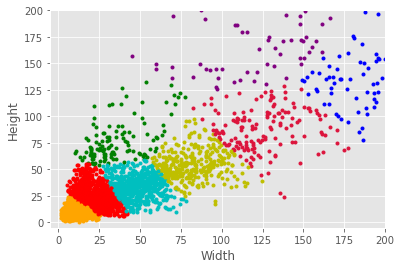

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline

some_ones = bounding_boxes[::200]
pred = y_pred[::200]
colors = ['r','b','orange','purple','y','g', 'b', 'c', 'crimson']

plt.style.use('ggplot')
for idx, bb in enumerate(some_ones):
    plt.plot(bb[0], bb[1], color = colors[pred[idx]], marker = '.')
plt.axis([-5,200,-5,200])
plt.xlabel('Width')
plt.ylabel('Height')



In [12]:
yolo_anchors = np.array([(10, 10), (22, 23), (47, 33), (39, 81), (82, 54), (127, 86),
                         (118, 168), (194, 130), (257, 221)], np.float32)
masks = [[0,1,2],
         [3,4,5],
         [6,7,8]]

## Data Processing
We need to create a proper tf.data.Dataset object with an iterator (cause otherwise it won't fit in memory).
To do that we need to scale the inputs, both the image and the labels.
Since the output of the network is like *13x13x3x(4+1+num_classes)* we also need to format our ground truth into such a matrix first, in order to calculate the delta (more or less)

In [13]:
BATCH_SIZE = 32
IMG_DIMENSION = 1920
SCALE = 1
# GRID SIZE
SMALL = 35
MEDIUM = 70
LARGE = 140

### Resizing images

We're following the paper approach and resize to a box-shaped input with *gray padding* instead of streching the input.

In [14]:
def load_n_resize_image(img_path, inp_dim):
    img = cv2.imread(img_path)
    img_w, img_h = img.shape[1], img.shape[0]
    scale = min(inp_dim/img_w, inp_dim/img_h)
    new_w = int(img_w * scale)
    new_h = int(img_h * scale)
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim, inp_dim, 3), 128)

    canvas[(inp_dim-new_h)//2:(inp_dim-new_h)//2 + new_h,(inp_dim-new_w)//2:(inp_dim-new_w)//2 + new_w,  :] = resized_image
    canvas = canvas[:,:,::-1].copy()
    output = tf.convert_to_tensor(canvas)
    return output

### Formatting Label
We want the label to be ok with the loss function we want to use. We're gonna do it *before* resizing so be aware of that.

NOTE: To do this in a proper way i should have done that with tf operation. Instead, on this whole Notebook i used regular python / NumPy based on how lazy i was on that moment.

UPDATED: I decided to load and resave every json in a YOLOv3 compatible format, such that i have the ground trouth avalaible in a friendly format.

In [37]:
label_dir = pathlib.Path.cwd().joinpath('dataset_bdd', 'labels', 'train_jsons')
pathlist_label = label_dir.glob('*.json')
example = label_dir.joinpath('0a0a0b1a-7c39d841.jpg.json')

def load_single_json(path):
    with open(path, 'r') as read_file:
        data = json.load(read_file)
    objects = data_encoding(data)
    return objects

def find_best_anchor(bb, anchors = yolo_anchors, scale = SCALE):
    ## assuming bb is like [x,y,w,h]
    bb = np.array(bb)
    anchors = anchors / SCALE
    ## we can just assume all anchors and the ground truth box share the same centroid. And with this assumption
    ## the degree of matching would be the overlapping area, which can be calculated by min width * min height.
    broadcast_IoU = np.zeros(9)
    for index, anchor in enumerate(anchors):
        intersection = np.minimum(anchor[0],bb[2]) * np.minimum(anchor[1],bb[3])
        union = bb[2]*bb[3] + anchor[0]*anchor[1] - intersection
        broadcast_IoU[index] = intersection/union
    best_one = np.argmax(broadcast_IoU)
    return best_one

def data_encoding(data): #Convert the class labels given as a dict into one-hot vector encoding, and concatenate it with the bounding box coordinates.
    #It return a Tensorflow Tensor
    labels = tf.constant([])
    class_names = ['bus', 'traffic light', 'traffic sign', 'person', 'bike', 'truck', 'motor', 'car', 'train', 'rider']
    for index,obj in enumerate(data['labels']):
        label_class = class_names.index(obj['category'])
#         temp1 = tf.constant([round(x/(IMG_DIMENSION*SCALE) for x in obj['box2d'].values()], dtype=tf.float32)
        temp1_1 = tf.constant([obj['box2d']['xb']/(IMG_DIMENSION*SCALE)], dtype=tf.float32)
        temp1_2 = tf.constant([(obj['box2d']['yb']+420)/(IMG_DIMENSION*SCALE)], dtype=tf.float32)
        temp1_3 = tf.constant([obj['box2d']['wb']/(IMG_DIMENSION*SCALE)], dtype=tf.float32)
        temp1_4 = tf.constant([obj['box2d']['hb']/(IMG_DIMENSION*SCALE)], dtype=tf.float32)
        temp2 = tf.constant([1],dtype=tf.float32)                   
        temp3 = tf.one_hot(label_class, len(class_names))
        temp4 = tf.concat([temp1_1, temp1_2, temp1_3, temp1_4, temp2, temp3], 0)
        labels = tf.concat([labels,temp4], 0)
    labels = tf.reshape(labels, [-1,15])
    return labels

def preprocess_label_for_one_scale(grid_size, path = example):        
    if grid_size == 'small':
        grid_size = SMALL
        idx = 0
    elif grid_size == 'medium':
        grid_size = MEDIUM
        idx = 1
    elif grid_size == 'large':
        grid_size = LARGE
        idx = 2
    else: raise ValueError('expected small, medium or large')
        
    y = np.zeros((grid_size, grid_size, 3, 5 + 10))
    objects = load_single_json(path)
#     cell_side = IMG_DIMENSION / SCALE / grid_size
    for item in objects:
        ## Finding the right place in the grid
        column, row = int(np.floor(item[0]*grid_size)), int(np.floor(item[1]*grid_size))
    
#         ## Rescaling the values x,y to be between 0 and 1 inside the cell
#         new_x = (item[0]%cell_side)/cell_side
#         new_y = (item[1]%cell_side)/cell_side

            
        ## Finding the best anchor
        anchor = find_best_anchor(item)
        if anchor in masks[idx]:
                y[row, column, anchor%3, :] = item
    return y

def preprocess_label(path = example):
    output = (tf.convert_to_tensor(preprocess_label_for_one_scale('small')),
              tf.convert_to_tensor(preprocess_label_for_one_scale('medium')),
              tf.convert_to_tensor(preprocess_label_for_one_scale('large')))
    return output
    

In [38]:
# for idx, path in enumerate(pathlist_label):
preprocess_label()

(<tf.Tensor: shape=(35, 35, 3, 15), dtype=float64, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],


### Loading the Data
Here we need to implement an iterator in order to load and process the data with the functions above.

In [83]:
#Here below a function to convert a file path to a tuple with both image and labels

data_dir = str(pathlib.Path.cwd().joinpath('dataset_bdd', 'images', '100k'))
pathlist_img = pathlib.Path(data_dir).glob('train/*.jpg')


def get_label(image_path): #Given the image path, it loads the labels from the JSON
    if isinstance(image_path, str):
        image_path = pathlib.Path(image_path)
    file_name = image_path.name + '.json'
    label_path = image_path.parent.parent.parent.parent.joinpath('labels', 'train_jsons', file_name)
    labels = preprocess_label(label_path)
    return labels

def process_path(file_path): #Given an image path, it return a tuple (img, labels) where both are tensors
    labels = get_label(file_path)
    # load the raw data from the file as a string
    file_path = tf.constant(str(file_path))
    img = load_n_resize_image(file_path, IMG_DIMENSION)
    return img, labels

def dataset_generator():
    for path in pathlist_img:
        img, labels = process_path(path)
        yield img, labels 

### Generating the tf.data.Dataset

In [87]:
dataset = tf.data.Dataset.from_generator(dataset_generator, (tf.uint8, tf.float32) ,
                                         (tf.TensorShape([IMG_DIMENSION, IMG_DIMENSION, 3]),
                                          (tf.TensorShape([None, 15]))))
print(dataset)

dataset_s = dataset.shuffle(70000, reshuffle_each_iteration=False)
print(dataset)

val_size = int(7000)
train_ds = dataset_s.skip(val_size)
val_ds = dataset_s.take(val_size)

print(train_ds)
print(val_ds)


<FlatMapDataset shapes: ((1920, 1920, 3), (None, 15)), types: (tf.uint8, tf.float32)>
<FlatMapDataset shapes: ((1920, 1920, 3), (None, 15)), types: (tf.uint8, tf.float32)>
<SkipDataset shapes: ((1920, 1920, 3), (None, 15)), types: (tf.uint8, tf.float32)>
<TakeDataset shapes: ((1920, 1920, 3), (None, 15)), types: (tf.uint8, tf.float32)>
